In [2]:
# I always like to structure my imports into Python's native libs,
# stuff I installed via conda/pip and local file imports (but we don't have those here)

import pickle
from tqdm import tqdm

# Visualization related imports
import matplotlib.pyplot as plt
import networkx as nx
import igraph as ig

# Main computation libraries
import scipy.sparse as sp
import numpy as np

# Deep learning related imports
import torch

In [3]:
"""
    Contains constants needed for data loading and visualization.

"""

import os
import enum


# Supported datasets - only MOOCCubeX in this notebook
class DatasetType(enum.Enum):
    MOOCCubeX = 0

    
class GraphVisualizationTool(enum.Enum):
    NETWORKX = 0,
    IGRAPH = 1


# We'll be dumping and reading the data from this directory
DATA_DIR_PATH = '../data'
MCX_PATH = os.path.join(DATA_DIR_PATH, 'MOOCCubeX')  # this is checked-in no need to make a directory
print(f"DATA_DIR_PATH: {MCX_PATH}")

TRAIN_RANGE = [0, 33417870]
TEST_RANGE = [33417870, 134580654]

# CORA_NUM_INPUT_FEATURES = ?
NUM_CLASSES = 2

NUM_USERS = 694529

USER = 0
COURSE = 1
node_class_to_color_map = {0: "black", 1: "blue"}
edge_label_to_color_map = {0: "red", 1: "green"}

DATA_DIR_PATH: ../data/MOOCCubeX


In [4]:
def numpy_read(path):
    with open(path, 'rb') as file:
        data = np.load(file)

    return data

def pickle_read(path):
    with open(path, 'rb') as file:
        data = pickle.load(file)

    return data

def numpy_save(path, data):
    with open(path, 'wb') as file:
        np.save(file, data)
        
def pickle_save(path, data):
    with open(path, 'wb') as file:
        pickle.dump(data, file)

    return data

In [5]:
# train_items = pickle_read(os.path.join(MCX_PATH, 'train_items_4.pkl'))
# test_items = pickle_read(os.path.join(MCX_PATH, 'test_items_50.pkl'))
# train_embeddings = pickle_read(os.path.join(MCX_PATH, 'train_embeddings_4_64.pkl'))
# test_embeddings = pickle_read(os.path.join(MCX_PATH, 'test_embeddings_50_64.pkl'))

# max(test_items)
# len(train_items)

In [6]:
# train_embeddings[0].numpy().shape

In [25]:
# # Create User Nodes and Item Nodes
import networkx as nx
G = nx.Graph()

train_users = pickle_read(os.path.join(MCX_PATH, 'train_users_4.pkl'))
distinct_train_users = set(train_users)
train_labels = pickle_read(os.path.join(MCX_PATH, 'train_ratings_4.pkl'))

max_user_id = max(distinct_train_users)


print(f"max_user_id: {max_user_id}")

print(f"len(train_users): {len(train_users)}")

max_user_id
train_items = pickle_read(os.path.join(MCX_PATH, 'train_items_4.pkl'))
ajusted_train_items = list(map(lambda x: x+max_user_id+1, train_items))

distinct_train_items = set(ajusted_train_items)

nodes = distinct_train_users.union(distinct_train_items)

print(f"len(nodes): {len(nodes)}", max(nodes))

for node in tqdm(nodes):
    G.add_node(node)


for i in tqdm(range(len(train_users))):
    if train_labels[i] == 1:
        G.add_edge(train_users[i], ajusted_train_items[i])


max_user_id: 694528
len(train_users): 33417870
len(nodes): 699229 699228


100%|██████████| 33417870/33417870 [00:21<00:00, 1547010.54it/s]


In [26]:
nx.average_clustering(G)

0.0

In [ ]:
# Create Edge Labels
# train_labels = pickle_read(os.path.join(MCX_PATH, 'train_ratings_4.pkl'))
# test_labels = pickle_read(os.path.join(MCX_PATH, 'test_ratings_50.pkl'))
# all_labels = train_labels + test_labels
# npy_labels = np.array(all_labels, dtype=np.int32)
# np.save(os.path.join(MCX_PATH, 'labels.npy'), npy_labels)
# npy_labels.dtype

In [ ]:
# Create Edge Labels
# train_labels = pickle_read(os.path.join(MCX_PATH, 'train_ratings_4.pkl'))
# test_labels = pickle_read(os.path.join(MCX_PATH, 'test_ratings_50.pkl'))
# all_labels = train_labels + test_labels
# npy_labels = np.array(all_labels, dtype=np.int32)
# np.save(os.path.join(MCX_PATH, 'labels.npy'), npy_labels)
# npy_labels.dtype

In [ ]:
# nodes = np.array(list(nodes), dtype=np.int32)
# edges = np.array(edges, dtype=np.int32)

In [ ]:
# numpy_save(os.path.join(MCX_PATH, 'nodes.npy'), nodes)
# numpy_save(os.path.join(MCX_PATH, 'edges.npy'), edges)

In [ ]:
TRAIN_RANGE = [0, 33417870]
# nodes = numpy_read(os.path.join(MCX_PATH, 'nodes.npy'))
# edges =numpy_read(os.path.join(MCX_PATH, 'edges.npy'))
# nodes.shape[0], max(nodes)

In [ ]:
# Find Node Features
# BERT_FEATURES_SIZE = 768
# node_features = np.zeros((nodes.shape[0], BERT_FEATURES_SIZE))

# for i in tqdm(range(len(train_items))):
#     item_id = train_items[i] + NUM_USERS
#     node_features[item_id] = train_embeddings[i].numpy()
# node_features

In [ ]:
# import scipy
# import scipy.sparse
# node_features_csr = scipy.sparse.csc_matrix(node_features)

# pickle_save(os.path.join(MCX_PATH, 'node_features_csr.pkl'), node_features_csr)

In [ ]:
# edges = np.transpose(edges)

In [ ]:
# edges.shape

In [ ]:
# We'll pass the training config dictionary a bit later
def load_graph_data(training_config, device):
    dataset_name = training_config['dataset_name'].lower()
    should_visualize = training_config['should_visualize']
    just_train = training_config['just_train']

    if dataset_name == DatasetType.MOOCCubeX.name.lower():

        # shape = (N, 768), where N is the number of nodes
        node_features = pickle_read(os.path.join(MCX_PATH, 'node_features_csr.pkl')).todense()
        # shape = (E, 2) 
        edges = numpy_read(os.path.join(MCX_PATH, 'edges.npy'))
        if just_train:
            edges = edges[TRAIN_RANGE[0]:TRAIN_RANGE[1]]
        # shape = (E,)
        edge_labels = numpy_read(os.path.join(MCX_PATH, 'labels.npy'))
        if just_train:
            edge_labels = edge_labels[TRAIN_RANGE[0]:TRAIN_RANGE[1]]

        num_of_nodes = node_features.shape[0]

        # shape = (2, E), where E is the number of edges, and 2 for source and target nodes. Basically edge index
        # contains tuples of the format S->T, e.g. 0->3 means that node with id 0 points to a node with id 3.
        topology = np.transpose(edges)

        # Note: topology is just a fancy way of naming the graph structure data 
        # (aside from edge index it could be in the form of an adjacency matrix)

        if should_visualize:  # network analysis and graph drawing
            plot_in_out_degree_distributions(topology, num_of_nodes, dataset_name)  # we'll define these in a second
            visualize_graph(topology, edge_labels, dataset_name)

        # Convert to dense PyTorch tensors

        # Needs to be long int type because later functions like PyTorch's index_select expect it
        topology = torch.tensor(topology, dtype=torch.long, device=device)
        edge_labels = torch.tensor(edge_labels, dtype=torch.long, device=device)  # Cross entropy expects a long int
        node_features = torch.tensor(node_features, dtype=torch.float32, device=device)

        # Indices that help us extract nodes that belong to the train/val and test splits
        train_indices = torch.arange(TRAIN_RANGE[0], TRAIN_RANGE[1], dtype=torch.long, device=device)
        test_indices = torch.arange(TEST_RANGE[0], TEST_RANGE[1], dtype=torch.long, device=device)

        return node_features, edge_labels, topology, train_indices, test_indices
    else:
        raise Exception(f'{dataset_name} not yet supported.')

In [3]:
# Let's just define dummy visualization functions for now - just to stop Python interpreter from complaining!
# We'll define them in a moment, properly, I swear.

# def plot_in_out_degree_distributions():
#     pass

# def visualize_graph():
#     pass

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # checking whether you have a GPU
# device = torch.device("cpu")

# config = {
#     'dataset_name': DatasetType.MOOCCubeX.name,
#     'should_visualize': False,
#     'just_train': True
# }
# node_features, edge_labels, edge_index, train_indices, test_indices = load_graph_data(config, device)

# print(node_features.shape, node_features.dtype)
# print(edge_labels.shape, edge_labels.dtype)
# print(edge_index.shape, edge_index.dtype)
# print(train_indices.shape, train_indices.dtype)
# print(test_indices.shape, test_indices.dtype)

NameError: name 'torch' is not defined

In [14]:
count = 0
for u, v in tqdm(G.edges()):
    print(u, v)
    count += 1
    if count > 10:
        break

  0%|          | 10/6683574 [00:00<01:36, 69327.34it/s]

0 696595
0 696860
0 698575
0 698652
0 695008
1 697022
1 696137
1 696155
1 696368
2 698786
2 694638


In [17]:
def plot_in_out_degree_distributions(G):
    """
        Note: It would be easy to do various kinds of powerful network analysis using igraph/networkx, etc.
        I chose to explicitly calculate only the node degree statistics here, but you can go much further if needed and
        calculate the graph diameter, number of triangles and many other concepts from the network analysis field.

    """

    # Store each node's input and output degree (they're the same for undirected graphs such as Cora)

    user_degree = np.zeros(NUM_USERS, dtype=int)
    course_degree = np.zeros(G.number_of_nodes() - NUM_USERS - 1, dtype=int)

    # Edge index shape = (2, E), the first row contains the source nodes, the second one target/sink nodes
    # Note on terminology: source nodes point to target/sink nodes
    for source_node_id, target_node_id in tqdm(G.edges()):
        if user_degree[source_node_id -1] < 100:
            user_degree[source_node_id - 1] += 1  # source node points towards some other node -> increment its out degree
        if course_degree[target_node_id - NUM_USERS - 1] < 100:
            course_degree[target_node_id - NUM_USERS - 1] += 1  # similarly here


    fig = plt.figure(figsize=(12,8), dpi=100)  # otherwise plots are really small in Jupyter Notebook
    fig.subplots_adjust(hspace=0.6)

    plt.subplot(311)
    plt.plot(user_degree, color='red')
    plt.xlabel('node id'); plt.ylabel('user-degree count'); plt.title('Degree for different user ids')

    plt.subplot(312)
    plt.plot(course_degree, color='green')
    plt.xlabel('node id'); plt.ylabel('course-degree count'); plt.title('Degree for different course ids')

    plt.subplot(313)
    plt.hist(course_degree, bins=50)
    plt.xlabel('node degree')
    plt.ylabel('# nodes for a given out-degree') 
    plt.title(f'Node course-degree distribution for MOOCCubeX dataset')

    plt.grid(True)
    plt.show()

100%|██████████| 6683574/6683574 [00:05<00:00, 1119300.44it/s]


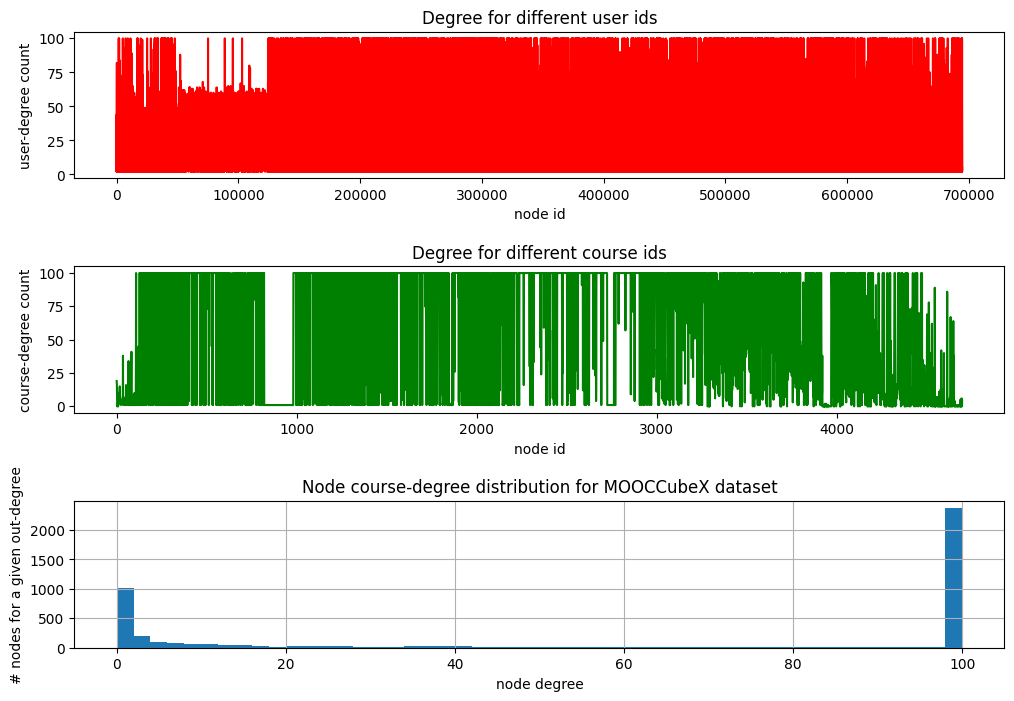

In [18]:
plot_in_out_degree_distributions(G)

In [21]:

# nodes = torch.tensor(np.arange(0, 10, dtype=np.int32), dtype=torch.int64)
# nodes
# edges_1 = np.random.choice(10, 15)
# edges_2 = np.random.choice(10, 15)
# edges = np.array([edges_1, edges_2], dtype=np.int32)
# edges = torch.tensor(edges, dtype=torch.int64)
# edges.shape, nodes.shape

In [22]:
# node_features = torch.rand(10, 20)
# node_features.shape

In [23]:
# labels = torch.randint(0, 2, (15,))
# labels

In [24]:
# train_indices = torch.tensor(range(0, 10), dtype=torch.int64)
# train_indices
# test_indices = torch.tensor(range(10,15), dtype=torch.int64)
# test_indices

In [25]:
# train_labels = labels.index_select(0, train_indices)
# test_labels = labels.index_select(0, test_indices)
# graph_data = (node_features, edges)
# train_labels.shape, test_labels.shape

In [26]:
# import os, sys
# dir2 = os.path.abspath('')
# dir1 = os.path.dirname(dir2)
# if not dir1 in sys.path: sys.path.append(dir1)
# from architectures.gat import GAT

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
# print(f'Using device: {device}')

# graph_data = (node_features.to(device), edge_index.to(device))

# config = {
#     "num_of_layers": 2,  # GNNs, contrary to CNNs, are often shallow (it ultimately depends on the graph properties)
#     "num_heads_per_layer": [8, 1],
#     "num_features_per_layer": [768, 8, 1],
#     "add_skip_connection": False, 
#     "bias": False,  # result is not so sensitive to bias
#     "dropout": 0.6,  # result is sensitive to dropout
# }

# gat = GAT(
#         num_of_layers=config['num_of_layers'],
#         num_heads_per_layer=config['num_heads_per_layer'],
#         num_features_per_layer=config['num_features_per_layer'],
#         add_skip_connection=config['add_skip_connection'],
#         bias=config['bias'],
#         dropout=config['dropout'],
#         log_attention_weights=False  # no need to store attentions, used only in playground.py for visualizations
#     ).to(device)

# preds = gat(graph_data)[0]

In [27]:
# preds.shape, edge_index.shape

In [28]:
# data = edge_index.numpy().T
# new_array = [tuple(row) for row in data]
# uniques = set(new_array)
# len(uniques)

In [29]:
"""NEU illustrative example."""

# import networkx as nx
# from karateclub.node_embedding.meta import NEU
# from karateclub.node_embedding.neighbourhood import GLEE

# g = nx.newman_watts_strogatz_graph(69920, 20, 0.05)

# model = GLEE(dimensions=64)

# meta_model = NEU()

# print(g.number_of_nodes(), g.number_of_edges())
# meta_model.fit(g, model)
# embs = meta_model.get_embedding()


# # numpy_save(os.path.join(MCX_PATH, 'glee_embeddings.npy'), embs)
# type(embs), embs.shape

'NEU illustrative example.'

In [30]:
import io
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg

# G = nx.from_edgelist(edges)
# G.number_of_nodes(), G.number_of_edges()

In [31]:
# import networkx as nx
# from karateclub.node_embedding.meta import NEU
# from karateclub.node_embedding.neighbourhood import GLEE
# model = GLEE()

# meta_model = NEU()

# print(G.number_of_nodes(), G.number_of_edges())
# meta_model.fit(G, model)
# embs = meta_model.get_embedding()
# numpy_save(os.path.join(MCX_PATH, 'glee_embeddings.npy'), embs)
# type(embs), embs.shape

In [32]:
embs = numpy_read(os.path.join(MCX_PATH, 'glee_embeddings.npy')).astype(np.float32)
numpy_save(os.path.join(MCX_PATH, 'glee_embeddings.npy'), embs)
embs.dtype, embs.shape, embs.nbytes

(dtype('float32'), (699229, 129), 360802164)

In [45]:


train_users = pickle_read(os.path.join(MCX_PATH, 'train_users_4.pkl'))
print(f"len(train_users): {len(train_users)}")

train_items = pickle_read(os.path.join(MCX_PATH, 'train_items_4.pkl'))
print(f"len(train_items): {len(train_items)}")

emb_matrix = []
max_id = 0
for i in tqdm(range(int(len(train_users)))):
    user = train_users[i]
    item = train_items[i] - NUM_USERS

    if max_id < user or max_id < item + NUM_USERS:
        max_id = max(max_id, user, item + NUM_USERS)
        print(f"max_id: {max_id}")

    user_emb = embs[user]
    item_emb = embs[item]
    cat_emb = np.concatenate((user_emb, item_emb), axis=0)
    cat_emb = torch.tensor(cat_emb, dtype=torch.float32)
    emb_matrix.append(cat_emb)
    
len(emb_matrix)

len(train_users): 33417870
len(train_items): 33417870


  0%|          | 0/33417870 [00:00<?, ?it/s]

max_id: 419025
max_id: 652087
max_id: 652968
max_id: 665610
max_id: 686482
max_id: 691546
max_id: 691561
max_id: 691864
max_id: 692061
max_id: 692829
max_id: 693474


  0%|          | 49945/33417870 [00:00<04:59, 111227.78it/s]

max_id: 693592
max_id: 694182
max_id: 694403
max_id: 694450
max_id: 694508
max_id: 694510


  0%|          | 157626/33417870 [00:01<04:20, 127854.23it/s]

max_id: 694511
max_id: 694512
max_id: 694514
max_id: 694519
max_id: 694528


100%|██████████| 33417870/33417870 [03:06<00:00, 179256.89it/s]


33417870

In [46]:
embeddings = pickle_read(os.path.join(MCX_PATH, 'train_embeddings_4_64.pkl'))
len(embeddings)

In [44]:
for i in tqdm(range(len(embeddings))):
    if embeddings[i].nbytes != 3072:
        print(embeddings[i].nbytes, len(embeddings), len(embs))
        break

100%|██████████| 33417870/33417870 [00:04<00:00, 6705271.35it/s]
